<a href="https://colab.research.google.com/github/whoami-Lory271/thesis-project/blob/main/thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Symbol legend

* B: batch size
* L: lookback window (aka input_size)


# Installations and imports


In [1]:
!pip install pytorch-lightning==2.0.1.post0 --quiet
!pip install einops==0.6.1 --quiet
!pip install ipdb --quiet
!pip install wandb --quiet
# !pip install objsize --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import logging
# https://github.com/gotcha/ipdb
import ipdb
import copy
from google.colab import drive
from tqdm.notebook import tqdm
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.profiler import profile, record_function, ProfilerActivity
import numpy as np
import random
# https://theaisummer.com/einsum-attention/
import einops
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.profilers import PyTorchProfiler
from pytorch_lightning.tuner import Tuner

import wandb
import sys
import pickle
import time
import os
import torch.fft as fft
# import objsize

In [3]:
drive.mount('/content/drive')
!cp /content/drive/MyDrive/Tesi/code/.netrc /root/
wandb.login()
# 024a3906e525e6d2640af94c364128bb3d33e44b

Mounted at /content/drive


wandb: Currently logged in as: desantis-1849114 (desantis). Use `wandb login --relogin` to force relogin


True

# Helper Functions

In [4]:
# setup logger function
def setup_log(self, level):
    log = logging.getLogger(self.__class__.__name__)
    log.setLevel(level)
    return log

In [5]:
# write log on a file
def write_log(a):
    with open("log.txt", 'w') as file:
        for row in a:
            file.write(str(row))
        log.debug("object logged")

In [6]:
def get_patch_num(patch_len, num_var, stride):
    return (max(patch_len, num_var)-patch_len) // stride + 2

In [7]:
# pad array with nan
def pad_nan(arr, left=0, right=0, dim=0):
    # padding the right side
    if left > 0:
        padshape = list(arr.shape)
        padshape[dim] = left
        arr = torch.cat((torch.full(padshape, np.nan).to(arr.device), arr), dim=dim)

    # padding the left side
    if right > 0:
        padshape = list(arr.shape)
        padshape[dim] = right
        arr = torch.cat((arr, torch.full(padshape, np.nan)).to(arr.device), dim=dim)
    return arr

In [8]:
# split with nan
def split_with_nan(x, sections, axis=0):
    assert x.dtype in [np.float16, np.float32, np.float64]
    arrs = np.array_split(x, sections, axis=axis)
    target_length = arrs[0].shape[axis]
    for i in range(len(arrs)):
        arrs[i] = pad_nan_to_target(arrs[i], target_length, axis=axis)
    return arrs

In [9]:
# pad with nan
def pad_nan_to_target(array, target_length, axis=0):
    assert array.dtype in [np.float16, np.float32, np.float64]
    pad_size = target_length - array.shape[axis]
    if pad_size <= 0:
        return array
    npad = [(0, 0)] * array.ndim
    npad[axis] = (0, pad_size)

    return np.pad(array, pad_width=npad, mode='constant', constant_values=np.nan)

In [10]:
def centerize_vary_length_series(x):
    prefix_zeros = np.argmax(~np.isnan(x).all(axis=-1), axis=1)
    suffix_zeros = np.argmax(~np.isnan(x[:, ::-1]).all(axis=-1), axis=1)
    offset = (prefix_zeros + suffix_zeros) // 2 - prefix_zeros
    rows, column_indices = np.ogrid[:x.shape[0], :x.shape[1]]
    offset[offset < 0] += x.shape[1]
    column_indices = column_indices - offset[:, np.newaxis]

    return x[rows, column_indices]

In [11]:
# random seed functions
def seed_everything(seed):
    pl.seed_everything(seed, workers=True)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [12]:
# pickle helper
def pkl_save(name, var):
    os.makedirs(os.path.dirname(name), exist_ok=True)
    with open(name, 'wb') as f:
        pickle.dump(var, f)

def pkl_load(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

# Constants

In [13]:
# logger
LOG_LEVEL = logging.DEBUG

# datasets name
ELECTRICITY = "electricity"
M5 = "M5"
ETTh1 = "ETTh1"
ETTh2 = "ETTh2"
WEATHER = "WTH"


# models
CoSpy = "CoSpy"

MODEL = CoSpy
ENCODER = "Pyraformer" # TCN Pyraformer

# device

DEVICE = torch.device('cpu') if not torch.cuda.is_available() else torch.device('cuda')

#hyperparameters

DATASET = ELECTRICITY

# Train
BATCH_SIZE = 4
EPOCHS = None
ITERS = None
L = 201
UNIVARIATE = True

# Eval
EVALUATE = False
MAX_TRAIN_LENGTH = 201
PADDING = MAX_TRAIN_LENGTH-1
ENCODE_BATCH_SIZE = 256


# training
TRAIN = True
DETERMINISTIC = True
LOAD_MODEL = False
RESUME_TRAINING = False
MEMORY_PROFILING = False
LOAD_ENCODE = False

# training techniques

GRADIENT_CLIPPING = None # None is default, 0.5 is by norm
FIND_LR = True

# wandb

RUN_ID = "RUN_ID"
RESUME_RUN = False
RUN_ID = wandb.util.generate_id() if not RESUME_RUN else RUN_ID
print(f"current RUN_ID is {RUN_ID}")

config = dict(
    epochs= EPOCHS,
    batch_size=BATCH_SIZE,
    dataset=DATASET,
    architecture=MODEL,
    run_id = RUN_ID)


#paths
MODEL_SETTINGS_FOLDER = "/univariate" if UNIVARIATE else "/multivariate"
ROOT_FOLDER = "/content/drive/MyDrive/Tesi/code"
MODEL_FOLDER = ROOT_FOLDER + "/models"
CHECKPOINT_FOLDER = ROOT_FOLDER + "/checkpoints" + "/" + MODEL + MODEL_SETTINGS_FOLDER
LOGS_FOLDER = ROOT_FOLDER + "/logs"
ENCODING_FOLDER = ROOT_FOLDER + "/encoding/" + MODEL + MODEL_SETTINGS_FOLDER
FORECASTING_RESULT = ROOT_FOLDER + "/forecasting_result/" + MODEL + MODEL_SETTINGS_FOLDER

current RUN_ID is voyn766d


In [14]:
datasets_path = {
    ELECTRICITY: ROOT_FOLDER + "/datasets/electricity"
}

datasets_name = {
    ELECTRICITY: "/LD2011_2014.txt"
}
datasets_processed_name = {
    ELECTRICITY: "/electricity.csv" #"/electricity.npy"
}

datasets_pred_lens = {
    ELECTRICITY: [24, 48], # [24, 48, 168, 336, 720]
    ETTh1: [24, 48],
    ETTh2: [24, 48],
    WEATHER: [24, 48],
    M5: [28]
}

datasets_n_iters = {
    ELECTRICITY: 600
}

ADJUST_LR, ITERS = (True, ITERS) if EPOCHS is not None or ITERS is not None else (False, datasets_n_iters[DATASET])

# WanDB

In [15]:
# start a new experiment
run = wandb.init(project=config["architecture"], config = config, id = config["run_id"], resume = 'allow')
ENCODING_FOLDER += "/" + run.name
FORECASTING_RESULT += "/" + run.name
CHECKPOINT_FOLDER += "/" + run.name

# Logger

In [16]:
# create logger
log = logging.getLogger('APP')
log.setLevel(LOG_LEVEL)
logging.basicConfig(level=LOG_LEVEL)

# # create console handler and set level to debug
# ch = logging.StreamHandler()
# ch.setLevel(logging.INFO)

# # create formatter
# formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# # add formatter to ch
# ch.setFormatter(formatter)

# # add ch to logger
# logger.addHandler(ch)

# Dataset and Datamodule

In [17]:
class CustomDataset(Dataset):
    def __init__(self, data, sigma, eval_mode = False,p = 0.5, multiplier = 10):
        super().__init__()
        self.data = data
        self.sigma = sigma
        self.eval_mode = eval_mode
        self.p = p
        self.multiplier = multiplier
        self.N, self.T, self.D = data.shape # num_ts, time, dim

    def __len__(self):
        # return self.data.shape[0] // self.look_window
        return self.data.shape[0] * self.multiplier

    def __getitem__(self, idx):
        ts = self.data[idx % self.N]

        return self.transform(ts), self.transform(ts)

    def get_len(self):
        return self.__len__()

    # def get_channels(self):
    #     return self.data.iloc[0, 1:].astype(str).str.replace(',', '.').astype('float32').shape[0]

    def transform(self, x):
        return self.jitter(self.shift(self.scale(x)))

    def jitter(self, x):
        if random.random() > self.p:
            return x
        return x + (torch.empty(x.shape).normal_(mean = 0, std = 0.5) * self.sigma)

    def scale(self, x):
        if random.random() > self.p:
            return x
        return x * (torch.empty(x.size(-1)).normal_(mean = 0, std = 0.5) * self.sigma + 1)

    def shift(self, x):
        if random.random() > self.p:
            return x
        return x + (torch.empty(x.size(-1)).normal_(mean = 0, std = 0.5) * self.sigma)

class CustomDataModule(pl.LightningDataModule):
    def __init__(self, name, path, batch_size, max_train_length, pred_lens = [24, 48, 96, 288, 672],
                 encode_batch_size = 256, train_size = 0.6, test_size = 0.2, univariate = False):
        super().__init__()
        self.path = path # path to csv file
        self.batch_size = batch_size
        self.encode_batch_size = encode_batch_size
        self.max_train_length = max_train_length
        self.pred_lens = pred_lens
        self.padding = max_train_length-1
        self.train_size = train_size
        self.test_size = test_size
        self.univariate = univariate
        self.name = name
        # self.data = np.load(path)

    # def prepare_data(self):
    #     # download

    def _get_time_features(self,dt):
        return np.stack([
                dt.minute.to_numpy(),
                dt.hour.to_numpy(),
                dt.dayofweek.to_numpy(),
                dt.day.to_numpy(),
                dt.dayofyear.to_numpy(),
                dt.month.to_numpy(),
                dt.weekofyear.to_numpy(),
            ], axis=1).astype(float)

    def _load_forecast_csv(self, path, name):
        data = pd.read_csv(path, index_col='date', parse_dates=True)
        dt_embed = self._get_time_features(data.index)
        n_covariate_cols = dt_embed.shape[-1]
        if self.univariate:
            if name in ('ETTh1', 'ETTh2', 'ETTm1', 'ETTm2'):
                data = data[['OT']]
            elif name == 'electricity':
                data = data[['MT_001']]
            elif name == 'WTH':
                data = data[['WetBulbCelsius']]
            else:
                data = data.iloc[:, -1:]
        data = data.to_numpy()
        # compute slices
        if name == 'ETTh1' or name == 'ETTh2':
            self.train_slice = slice(None, 12 * 30 * 24)
            self.valid_slice = slice(12 * 30 * 24, 16 * 30 * 24)
            self.test_slice = slice(16 * 30 * 24, 20 * 30 * 24)
        elif name == 'ETTm1' or name == 'ETTm2':
            self.train_slice = slice(None, 12 * 30 * 24 * 4)
            self.valid_slice = slice(12 * 30 * 24 * 4, 16 * 30 * 24 * 4)
            self.test_slice = slice(16 * 30 * 24 * 4, 20 * 30 * 24 * 4)
        elif name.startswith('M5'):
            self.train_slice = slice(None, int(0.8 * (1913 + 28)))
            self.valid_slice = slice(int(0.8 * (1913 + 28)), 1913 + 28)
            self.test_slice = slice(1913 + 28 - 1, 1913 + 2 * 28)
        else:
            self.train_slice = slice(None, int(self.train_size * len(data)))
            self.valid_slice = slice(int(self.train_size * len(data)), - int(self.test_size * len(data)))
            self.test_slice = slice(- int(self.test_size * len(data)), None)

        return data, dt_embed, n_covariate_cols

    def _scale_and_transform(self, data, dt_embed, n_covariate_cols, name):
        # scale data
        scaler = StandardScaler().fit(data[self.train_slice])
        data = scaler.transform(data)
        # NUM_ROWS x NUM_FEATURES -> NUM_FEATURES x NUM_ROWS x 1
        if name in ('electricity') or name.startswith('M5'):
            data = np.expand_dims(data.T, -1)  # Each variable is an instance rather than a feature
        else:
            data = np.expand_dims(data, 0)
        if n_covariate_cols > 0:
            dt_scaler = StandardScaler().fit(dt_embed[self.train_slice])
            dt_embed = np.expand_dims(dt_scaler.transform(dt_embed), 0)
            data = np.concatenate([np.repeat(dt_embed, data.shape[0], axis=0), data], axis=-1)

        return data, scaler, n_covariate_cols

    def _fit_setup(self, train_data):
        if self.max_train_length is not None:
            sections = train_data.shape[1] // self.max_train_length
        if sections >= 2:
            train_data = np.concatenate(split_with_nan(train_data, sections, axis=1), axis=0)

        temporal_missing = np.isnan(train_data).all(axis=-1).any(axis=0)
        if temporal_missing[0] or temporal_missing[-1]:
            train_data = centerize_vary_length_series(train_data)

        train_data = train_data[~np.isnan(train_data).all(axis=2).all(axis=1)]
        # pkl_save("/content/drive/MyDrive/Tesi/code/test/my_train_data.pkl", train_data)

        multiplier = 1 if train_data.shape[0] >= self.batch_size else math.ceil(self.batch_size / train_data.shape[0])

        return train_data, multiplier


    def setup(self, stage: str):
        # load csv
        data, dt_embed, n_covariate_cols = self._load_forecast_csv(self.path, self.name)

        # scale and transform
        self.data, self.scaler, self.n_covariate_cols = self._scale_and_transform(data, dt_embed, n_covariate_cols, self.name)

        # Assign train/val datasets for use in dataloaders
        if stage == "fit":
            train_data = self.data[:, self.train_slice]
            train_data, multiplier = self._fit_setup(train_data)
            # fit setup
            self.train = CustomDataset(torch.from_numpy(train_data).to(torch.float), sigma = 0.5, multiplier = multiplier)
            # self.validate = ElectricityDataset(data[self.valid_slice], self.look_window)
        if stage == 'encoding':
            self.encode = TensorDataset(torch.from_numpy(self.data).to(torch.float))




        # Assign test dataset for use in dataloader(s)
        # if stage == "test":
        #     self.test = ElectricityDataset(data[self.test_slice], self.look_window)

        # if stage == "predict":

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=min(self.batch_size, len(self.train)), drop_last = True, shuffle = True)

    def encode_dataloader(self):
        return DataLoader(self.encode, batch_size=self.encode_batch_size)

    # def test_dataloader(self):
    #     return DataLoader(self.test, batch_size=self.batch_size, drop_last = True)

    # def predict_dataloader(self):

## Preprocessing

### Electricity

In [18]:
# df = pd.read_csv(datasets_path[ELECTRICITY] + datasets_name[ELECTRICITY], sep = ';')
# df.rename(columns={df.columns[0]: 'Date'},inplace=True)
# values = df.values
# values = values[:, 1:].astype(str)
# for i, value in enumerate(values):
#   values[i] = np.char.replace(value, ",", ".")
# values = values.astype(np.float32)
# np.save(datasets_path[ELECTRICITY] + "/electricity", values)

In [19]:
# # # call this function to initialize the csv file
# def electricity_preprocess(path):
#     data_ecl = pd.read_csv(path + '/LD2011_2014.txt', parse_dates=True, sep=';', decimal=',', index_col=0)
#     data_ecl = data_ecl.resample('1h', closed='right').sum()
#     data_ecl = data_ecl.loc[:, data_ecl.cumsum(axis=0).iloc[8920] != 0]  # filter out instances with missing values
#     data_ecl.index = data_ecl.index.rename('date')
#     data_ecl = data_ecl['2012':]
#     data_ecl.to_csv(path + '/electricity.csv')
#     log.info("electriciy.csv created!")

In [20]:
# electricity_preprocess(datasets_path[ELECTRICITY])

# Models

## Vanilla Transformer Encoder

In [21]:
# VanillaTransformer encoder

"""
https://arxiv.org/pdf/1706.03762.pdf
"""

class VanillaTransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads = 16, dropout = 0.2):
        super(VanillaTransformerEncoder, self).__init__()

        self.log = setup_log(self, LOG_LEVEL)

        self.mha = MultiHeadAttention(d_model, n_heads)
        self.norm1 = nn.LayerNorm(d_model) # maybe batch normalization
        self.dropout1 = nn.Dropout(dropout)

        self.pffn = PositionWiseFeedForwardNetwork(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        # new variable because of residual connection
        z = self.mha(x,x,x)
        z = self.dropout1(z)
        z = self.norm1(z + x)

        # set the new value for the residual connection
        x = z
        z = self.pffn(z)
        z = self.dropout2(z)
        return self.norm2(z + x)

"""
ref: https://d2l.ai/chapter_attention-mechanisms-and-transformers/multihead-attention.html
"""
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, d_k, n_head = 6):
        super(MultiHeadAttention, self).__init__()

        self.log = setup_log(self, LOG_LEVEL)

        self.n_heads = n_head
        self.d_k = d_k

        self.W_q = nn.Linear(d_model, n_head * d_k, bias = False)
        self.W_k = nn.Linear(d_model, n_head * d_k, bias = False)
        self.W_v = nn.Linear(d_model, n_head * d_k, bias = False)
        self.W_o = nn.Linear(n_head * d_k, d_model, bias = False)

    # reshape to compute in parallel the several heads
    def reshape_vector(self, x, inverse = False):
        """
        x: (batch, input_size, d_model) || (batch, n_head, input_size, d_k)
        output: (batch, n_head, input_size, d_k) || (batch, input_size, d_model)
        """
        out = None

        if not inverse:
            out = einops.rearrange(x, 'b l (dim h) -> b h l dim', h=self.n_heads)
        else:
            out = einops.rearrange(x, 'b h l dim -> b l (dim h)')

        return out

    """
    ref: https://machinelearningmastery.com/the-transformer-attention-mechanism/
    """

    def scaled_attention(self, q, k, v, dk, mask = None):
        """
        q, k, v: (batch, n_head, input_size, d_k)
        output: (batch, n_head, input_size, d_k), (batch, n_head, input_size, input_size)
        """
        sqrt_d_k = math.sqrt(dk)

        # using einsum to perform batch matrix multiplication
        score = einops.einsum(q, k, 'b h l d_k, b h l_1 d_k -> b h l l_1') / sqrt_d_k

        if mask is not None:
            score = score.masked_fill(mask, -1e9)

        weights = F.softmax(score, dim = -1)
        attn = weights

        res = einops.einsum(weights, v, 'b h l l_1, b h l_1 d_k -> b h l d_k')

        return res, attn

    def forward(self, q, k, v, mask = None):
        """
        q, k, v: (batch, input_size, d_model)
        output: (batch, input_size, d_model), (batch, n_head, input_size, input_size)
        """
        residual = q

        q = self.reshape_vector(self.W_q(q))
        k = self.reshape_vector(self.W_k(k))
        v = self.reshape_vector(self.W_v(v))

        if mask is not None:
            if len(mask.size()) == 3:
                mask = mask.unsqueeze(1)  # For head axis broadcasting.

        # parallel computation
        out, attn = self.scaled_attention(q, k, v, self.d_k, mask)
        out_concat = self.reshape_vector(out, inverse = True)

        return self.W_o(out_concat) + residual, attn

class PositionWiseFeedForwardNetwork(nn.Module):
    def __init__(self, d_model, d_inner = 512):
        super(PositionWiseFeedForwardNetwork, self).__init__()

        self.log = setup_log(self, LOG_LEVEL)

        self.W_1 = nn.Linear(d_model, d_inner)
        self.act = nn.GELU()
        self.W_2 = nn.Linear(d_inner, d_model)

    def forward(self, x):
        """
        x: (batch, input_size, d_model)
        output: (batch, input_size, d_model)
        """
        res = x
        x = self.W_1(x)
        x = self.act(x)
        return res + self.W_2(x)

## PyraformerEncoder

### Helper Functions

In [22]:
def get_mask(input_size, window_size, inner_size, device):
    """Get the attention mask of PAM-Naive"""
    # Get the size of all layers
    all_size = []
    all_size.append(input_size)
    # we split the nodes in according with the number of children
    for i in range(len(window_size)):
        layer_size = math.floor(all_size[i] / window_size[i])
        all_size.append(layer_size)

    # length of the flattened graph
    seq_length = sum(all_size)
    # mask matrix
    mask = torch.zeros(seq_length, seq_length, device=device)

    # get intra-scale mask
    inner_window = inner_size // 2
    for layer_idx in range(len(all_size)):
        start = sum(all_size[:layer_idx])
        for i in range(start, start + all_size[layer_idx]):
            left_side = max(i - inner_window, start)
            right_side = min(i + inner_window + 1, start + all_size[layer_idx])
            mask[i, left_side:right_side] = 1

    # get inter-scale mask
    for layer_idx in range(1, len(all_size)):
        start = sum(all_size[:layer_idx])
        for i in range(start, start + all_size[layer_idx]):
            left_side = (start - all_size[layer_idx - 1]) + (i - start) * window_size[layer_idx - 1]
            if i == ( start + all_size[layer_idx] - 1):
                right_side = start
            else:
                right_side = (start - all_size[layer_idx - 1]) + (i - start + 1) * window_size[layer_idx - 1]
            mask[i, left_side:right_side] = 1
            mask[left_side:right_side, i] = 1

    mask = (1 - mask).bool()

    return mask, all_size

def get_graph_dim(input_size, window_size):
    """ get the dimension of the graph computed by CSCM"""
    res = input_size
    for w in window_size:
        input_size = math.floor(input_size / w)
        res += input_size

    return res



### Model

In [23]:
class Bottleneck_Construct(nn.Module):
    """Bottleneck convolution CSCM"""
    def __init__(self, d_model, window_size, d_inner):
        super(Bottleneck_Construct, self).__init__()
        if not isinstance(window_size, list):
            self.conv_layers = nn.ModuleList([
                ConvLayer(d_inner, window_size),
                ConvLayer(d_inner, window_size),
                ConvLayer(d_inner, window_size)
                ])
        else:
            self.conv_layers = []
            for i in range(len(window_size)):
                self.conv_layers.append(ConvLayer(d_inner, window_size[i]))
            self.conv_layers = nn.ModuleList(self.conv_layers)
        self.up = nn.Linear(d_inner, d_model)
        self.down = nn.Linear(d_model, d_inner)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, enc_input):

        temp_input = self.down(enc_input).permute(0, 2, 1)
        all_inputs = []
        for i in range(len(self.conv_layers)):
            temp_input = self.conv_layers[i](temp_input)
            all_inputs.append(temp_input)

        all_inputs = torch.cat(all_inputs, dim=2).transpose(1, 2)
        all_inputs = self.up(all_inputs)
        all_inputs = torch.cat([enc_input, all_inputs], dim=1)

        all_inputs = self.norm(all_inputs)

        return all_inputs
""" For Electricity Dataset"""
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        # create a positional array
        position = torch.arange(0, max_len).unsqueeze(1)
        # div term for half of positions
        div_term = torch.pow(10000.0, torch.arange(0, d_model, 2) / d_model)
        # even positions
        pe[:, 0::2] = torch.sin(position * div_term)
        # odd positions
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

        # if normalize:
        #     pe = pe - pe.mean()
        #     pe = pe / (pe.std() * 10)

    def forward(self, x):
        """
        output: (1, input_size, d_model)
        """
        return self.pe[:, :x.size(1)]

class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__>='1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                    kernel_size=3, padding=padding, padding_mode='circular')
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight,mode='fan_in',nonlinearity='leaky_relu')

    def forward(self, x):
        """
        x: (batch, input_size, enc_in)
        output: (batch, input_size, d_model)
        """
        x = self.tokenConv(einops.rearrange(x, 'b l e -> b e l')).transpose(1,2)
        return x

class CustomEmbedding(nn.Module):
    def __init__(self, c_in, d_model, temporal_size, seq_num, dropout=0.1):
        super(CustomEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = nn.Linear(temporal_size, d_model)
        self.seqid_embedding = nn.Embedding(seq_num, d_model)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        """
        x: (batch, input_size, enc_in)
        x_mark: (batch, input_size)
        output: (batch, input_size, d_model)
        """
        x = self.value_embedding(x) + self.position_embedding(x) + self.temporal_embedding(x_mark[:, :, :-1]) \
            + self.seqid_embedding(x_mark[:, :, -1].long())



        return self.dropout(x)

class EncoderLayer(nn.Module):
    """ Compose with two layers """

    def __init__(self, d_model, d_inner, d_k, n_head, dropout=0.1, normalize_before=True, q_k_mask=None, k_q_mask=None):
        super(EncoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(d_model, d_k, n_head)

        self.pos_ffn = PositionWiseFeedForwardNetwork(
            d_model, d_inner)

    def forward(self, enc_input, slf_attn_mask=None):
        """
        enc_input: (batch, input_size, d_model)
        output: (batch, input_size, d_model), (batch, n_head, input_size, input_size)
        """
        enc_output, enc_slf_attn = self.slf_attn(enc_input, enc_input, enc_input, mask=slf_attn_mask)

        enc_output = self.pos_ffn(enc_output)

        return enc_output, enc_slf_attn

class ConvLayer(nn.Module):
    def __init__(self, c_in, window_size):
        super(ConvLayer, self).__init__()
        self.downConv = nn.Conv1d(in_channels=c_in,
                                  out_channels=c_in,
                                  kernel_size=window_size,
                                  stride=window_size)
        self.norm = nn.BatchNorm1d(c_in)
        self.activation = nn.ELU()

    def forward(self, x):
        x = self.downConv(x)
        x = self.norm(x)
        x = self.activation(x)
        return x

class Bottleneck_Construct(nn.Module):
    """Bottleneck convolution CSCM"""
    def __init__(self, d_model, window_size, d_inner):
        super(Bottleneck_Construct, self).__init__()
        if not isinstance(window_size, list):
            self.conv_layers = nn.ModuleList([
                ConvLayer(d_inner, window_size),
                ConvLayer(d_inner, window_size),
                ConvLayer(d_inner, window_size)
                ])
        else:
            self.conv_layers = []
            for i in range(len(window_size)):
                self.conv_layers.append(ConvLayer(d_inner, window_size[i]))
            self.conv_layers = nn.ModuleList(self.conv_layers)
        self.up = nn.Linear(d_inner, d_model)
        self.down = nn.Linear(d_model, d_inner)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, enc_input):
        """
        enc_input: (batch, input_size, d_model)
        output: (batch, graph_size, d_model)
        """

        temp_input = self.down(enc_input).permute(0, 2, 1)
        all_inputs = []
        for i in range(len(self.conv_layers)):
            temp_input = self.conv_layers[i](temp_input)
            all_inputs.append(temp_input)

        all_inputs = torch.cat(all_inputs, dim=2).transpose(1, 2)
        all_inputs = self.up(all_inputs)
        # concat the computed new nodes with the input nodes
        all_inputs = torch.cat([enc_input, all_inputs], dim=1)

        all_inputs = self.norm(all_inputs)

        return all_inputs

class PyraformerEncoder(nn.Module):
    """ A encoder model with self attention mechanism. """

    def __init__(self, d_model = 320, d_k = 160, window_size = [4,4,4], inner_size = 3,
                 input_size = 201, d_inner_hid = 512, n_head = 6, n_layer = 4,
                 # Dataloader parameters
                 enc_in = 1, covariate_size = 7, seq_num = 321,
                 CSCM = "Bottleneck_Construct", d_bottleneck = 128, device = 'cpu'):
        super(PyraformerEncoder, self).__init__()
        self.log = setup_log(self, LOG_LEVEL)

        self.d_model = d_model # size of the latent vector
        self.d_k = d_k # size of the inner dimension of q, k, v
        self.window_size = window_size # The number of children of a parent node
        self.inner_size = inner_size # The number of ajacent nodes
        self.input_size = input_size # length of the sequence
        self.d_inner_hid = d_inner_hid # inner size of the PostitionalFeedForward
        self.n_head = n_head
        self.n_layer = n_layer
        self.enc_in = enc_in
        self.covariate_size = covariate_size # number of temporal covariate
        self.seq_num = seq_num # size of the time series
        self.CSCM = CSCM # called coarser-scale construction module
        self.g_size = get_graph_dim(input_size, window_size)
        self.d_bottleneck = d_bottleneck #
        self.mask, self.all_size = get_mask(self.input_size, self.window_size, self.inner_size, device)
        self.layers = nn.ModuleList([
                EncoderLayer(self.d_model, self.d_inner_hid, self.d_k, self.n_head) for i in range(self. n_layer)
                ])
        self.enc_embedding = nn.Linear(enc_in + covariate_size, d_model)#CustomEmbedding(self.enc_in, self.d_model, self.covariate_size, self.seq_num)

        self.conv_layers = eval(self.CSCM)(self.d_model, self.window_size, self.d_bottleneck)

        self.fc = nn.Linear(self.g_size, self.input_size)

        self.test = nn.Linear(enc_in + covariate_size, d_model)

    def forward(self, x):
        """
        x: (batch, input_size, enc_in + covariate_size)
        output: (batch, input_size, d_model)
        """

        seq_enc = self.enc_embedding(x)

        # Repeat the mask for all the batch
        mask = self.mask.repeat(len(seq_enc), 1, 1)

        seq_enc = self.conv_layers(seq_enc)

        for i in range(len(self.layers)):
            seq_enc, _ = self.layers[i](seq_enc, mask)

        seq_enc = einops.rearrange(seq_enc, 'b g d -> b d g')

        seq_enc = self.fc(seq_enc)

        seq_enc = einops.rearrange(seq_enc, 'b d l -> b l d')

        return seq_enc

## PatchTST

In [24]:
# Utility functions

def create_patches(xb, patch_len, stride):
    """
    xb -> [B x L x M] // [B x L x M x T]
    output -> [B x N x M x P] // [B x N x M x T x P], N
    """
    _, num_var, _, _ = xb.shape
    # compute number of patches
    patch_num = (max(patch_len, num_var)-patch_len) // stride + 2

    # we repeat the last variable of the sequence to have equal patches
    tail = torch.repeat_interleave(xb[:,-1:,...], stride, dim = 1)
    xb = torch.concatenate((xb, tail), axis = 1)

    # create patches
    xb = xb.unfold(dimension=1, size=patch_len, step=stride)

    assert patch_num == xb.shape[1], f"wrong number of computed patches, expected {patch_num} but computed {xb.shape[1]}"

    return xb, patch_num

"""
ref: https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
"""

def positional_encoding(batch_size, max_len, d_model):
    """
    output
    """
    pe = torch.zeros(batch_size, max_len, d_model)
    # create a positional array
    position = torch.arange(0, max_len).unsqueeze(1)
    # div term for half of positions
    div_term = torch.pow(10000.0, torch.arange(0, d_model, 2) / d_model)
    # even positions
    pe[:, :, 0::2] = torch.sin(position * div_term)
    # odd positions
    pe[:, :, 1::2] = torch.cos(position * div_term)

    # if normalize:
    #     pe = pe - pe.mean()
    #     pe = pe / (pe.std() * 10)

    return nn.parameter.Parameter(pe, requires_grad= False)

In [25]:
#PatchTST

class PatchTSTEncoder(nn.Module):
    def __init__(self, num_channels, num_var, patch_len, stride, batch_size, time_dimension = 8, d_model = 128, n_layers = 3, n_heads = 16, dropout = 0.2):
        super(PatchTSTEncoder, self).__init__()

        self.log = setup_log(self, LOG_LEVEL)

        self.num_channels = num_channels
        self.patch_num = (max(patch_len, num_var)-patch_len) // stride + 2
        self.patch_len = patch_len
        self.stride = stride
        self.batch_size = batch_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.dropout = dropout

        # instance normalization
        """
        ref: https://wandb.ai/wandb_fc/Normalization-Series/reports/Instance-Normalization-in-PyTorch-With-Examples---VmlldzoxNDIyNTQx
        """
        self.inst_norm = nn.InstanceNorm2d(num_channels)

        # patch creation
        self.create_patch = create_patches

        # embedding
        self.W_p = nn.Linear(patch_len * time_dimension, d_model, bias = False)

        # positional encoding
        self.W_pos = positional_encoding(batch_size * num_channels, self.patch_num, d_model)

        # dropout
        self.dropout = nn.Dropout(dropout)

        # encoder
        self.encoders = nn.ModuleList([VanillaTransformerEncoder(d_model) for _ in range(n_layers)])

    def forward(self, x):
        """
        x -> [B x L x M] // [(B x M) x MAX_TRAIN_LENGTH x TIME_DIM]
        output -> [(B M) x N x D]
        """
        b_m, _, _ = x
        assert b_m / self.num_channel == self.batch_size, f"invalid fisrt dimension {b_m / self.num_channel} != {self.batch_size}"
        # [(B M) x MAX_TRAIN_LENGTH x TIME_DIM] -> [B x M x MAX_TRAIN_LENGTH x TIME_DIM]
        x = einops.rearrange(x, '(b m) l t -> b m l t', m=self.num_channels)
        # we need to reshape dimensione before apply instance normalization
        x = einops.rearrange(self.inst_norm(x), 'b m l t -> b l m t')

        # create patches
        x, patch_num = self.create_patch(x, self.patch_len, self.stride)

        # x: [B x N x M x T x P]

        assert self.patch_num == patch_num, f"wrong number for patch_num {self.patch_num} != {patch_num}"

        # reshape the tensor from [B x N x M x T x P] -> [(B M) x N x (P T)]
        x = einops.rearrange(x, 'b n m t p -> (b m) n (p t)')
        # now it can be provided to our transformer implementation

        # project into transformer latent space
        x = self.W_p(x) + self.W_pos

        for layer in self.encoders:
            x = layer(x)

        return x



## TCN

In [26]:
class TCN(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims, depth):
        super(TCN, self).__init__()

        self.log = setup_log(self, LOG_LEVEL)

        self.input_fc = nn.Linear(input_dims, hidden_dims)

        self.feature_extractor = DilatedConvEncoder(
                hidden_dims,
                [hidden_dims] * depth + [output_dims],
                kernel_size=3
            )
    def forward(self, x):
        """
        x: (batch, input_size, enc_in + covariate_size)
        outputs: (batch, input_size, d_model)
        """
        x = self.input_fc(x)
        x = x.transpose(1, 2)
        x = self.feature_extractor(x)
        x = x.transpose(1, 2)
        return x

class DilatedConvEncoder(nn.Module):
    def __init__(self, in_channels, channels, kernel_size, extract_layers=None):
        super().__init__()

        if extract_layers is not None:
            assert len(channels) - 1 in extract_layers

        self.extract_layers = extract_layers
        self.net = nn.Sequential(*[
            ConvBlock(
                channels[i-1] if i > 0 else in_channels,
                channels[i],
                kernel_size=kernel_size,
                dilation=2**i,
                final=(i == len(channels)-1)
            )
            for i in range(len(channels))
        ])

    def forward(self, x):
        if self.extract_layers is not None:
            outputs = []
            for idx, mod in enumerate(self.net):
                x = mod(x)
                if idx in self.extract_layers:
                    outputs.append(x)
            return outputs
        return self.net(x)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, final=False):
        super().__init__()
        self.conv1 = SamePadConv(in_channels, out_channels, kernel_size, dilation=dilation)
        self.conv2 = SamePadConv(out_channels, out_channels, kernel_size, dilation=dilation)
        self.projector = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels or final else None

    def forward(self, x):
        residual = x if self.projector is None else self.projector(x)
        x = F.gelu(x)
        x = self.conv1(x)
        x = F.gelu(x)
        x = self.conv2(x)
        return x + residual

class SamePadConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, groups=1):
        super().__init__()
        self.receptive_field = (kernel_size - 1) * dilation + 1
        padding = self.receptive_field // 2
        self.conv = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            padding=padding,
            dilation=dilation,
            groups=groups
        )
        self.remove = 1 if self.receptive_field % 2 == 0 else 0

    def forward(self, x):
        out = self.conv(x)
        if self.remove > 0:
            out = out[:, :, : -self.remove]
        return out

## Cost

In [27]:
from torch.nn.modules.loss import TripletMarginWithDistanceLoss
#Cost

class Cost(nn.Module):
    def __init__(self, input_size, d_model = 320, d_s = 160, d_t = 160, n_layers = 3, n_heads = 6, dropout = 0.2):
        super(Cost, self).__init__()

        self.log = setup_log(self, LOG_LEVEL)

        # Dropout for seasonal representation output
        self.seasonal_drop = nn.Dropout(0.1)

        # Trend Feature Disentangler
        self.tfd = TrendFeatureDisentangler(d_model, d_t, input_size)

        # Seasonal Feature Disentangler
        self.sfd = SeasonalFeatureDisentangler(d_model, d_s, input_size)

    def forward(self, x):
        """
        x: (batch, input_size, d_model)
        outputs: (batch, input_size, d_t), (batch, input_size, d_s)
        """
        out_tfd = self.tfd(x)

        out_svd = self.sfd(x)

        out_svd = self.seasonal_drop(out_svd)

        return out_tfd, out_svd



# Causal Convolution (dilated)

class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super(CausalConv1d, self).__init__()

        self.log = setup_log(self, LOG_LEVEL)

        self.kernel_size = kernel_size
        pad = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=pad, dilation=dilation)

    def forward(self, x):
        """
        input: (batch, input_size, in_channels)
        output: (batch, conv_out, out_channels)
        """
        # we need to reshape before applying the convolution
        x = einops.rearrange(x, 'b l i_c -> b i_c l')
        x = self.conv(x)

        # we need to remove the trailing padding zeros (except for the fist layer) from the values
        if self.kernel_size > 1:
            x = x[...,0:-(self.kernel_size-1)]

        # rearrange to the original shape
        x = einops.rearrange(x, 'b o_c l -> b l o_c')

        return x

# TFD

class TrendFeatureDisentangler(nn.Module):
    def __init__(self, d_model, d_t, input_size):
        super(TrendFeatureDisentangler, self).__init__()

        self.log = setup_log(self, LOG_LEVEL)
        self.d_model = d_model
        self.d_t = d_t
        self.input_size = input_size

        # https://discuss.pytorch.org/t/causal-convolution/3456/3
        # https://arxiv.org/pdf/1609.03499v2.pdf

        # floor(log(N/2)) autoregressive expert
        self.conv_num = math.floor(math.log2(input_size / 2)) + 1
        self.kernel = [2**i for i in range(self.conv_num)]
        self.convolutions = nn.ModuleList([CausalConv1d(d_model, d_t, k) for k in self.kernel])

    def avg_pooling(self, input):
        """
        input: (list, batch, input_size, d_t)
        """
        return einops.reduce(input, 'list b l d_t -> b l d_t', 'mean')

    def forward(self, x):
        """
        x: (batch, input_size, d_model)
        output: (batch, input_size, d_t)
        """
        batch_size, input_size, d_model = x.shape

        assert input_size == self.input_size and d_model == self.d_model, "wrong input dimensions"

        # create the result tensor
        trend = torch.zeros(self.conv_num, batch_size, input_size, self.d_t, device = x.device)

        for i, conv in enumerate(self.convolutions):
            out = conv(x)
            trend[i,...] = out

        # apply the average pooling operation
        trend = self.avg_pooling(trend)

        return trend

# SVD

class SeasonalFeatureDisentangler(nn.Module):
    def __init__(self, d_model, d_s, input_size):
        super(SeasonalFeatureDisentangler, self).__init__()

        self.log = setup_log(self, LOG_LEVEL)

        self.input_size = input_size

        # number of frequencies after dft
        self.f = input_size // 2 + 1

        # discrete fast fourier transform, rfft output contains only the positive frequencies below the Nyquist frequency
        self.dft = torch.fft.rfft

        # Learnable Fourier Layer
        self.fl = FourierLayer(self.f, d_model, d_s, input_size)

        # inverse of discrete fast fourier transform
        self.idft = torch.fft.irfft



    def forward(self, x):
        """
        x: (batch, input_size, d_model)
        output: (batch, input_size, d_s)
        """
        # we apply dft along the temporal dimension
        x = self.dft(x, dim = 1)

        assert self.f == x.shape[1], "wrong dimension of dft"

        # apply fourier layer
        x = self.fl(x)

        # compute the inverse of dft to come back to time domain
        x = self.idft(x, n = self.input_size, dim = 1) # pass also the legth in order to avoid odd-length problems

        return x

class FourierLayer(nn.Module):
    def __init__(self, f, d_model, d_s, input_size):
        super(FourierLayer, self).__init__()

        self.log = setup_log(self, LOG_LEVEL)

        self.f = f
        self.d_model = d_model

        self.A = nn.Parameter(torch.empty((f, d_model, d_s), dtype=torch.cfloat))
        self.B = nn.Parameter(torch.empty((f, d_s), dtype=torch.cfloat))
        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.A)
        bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
        nn.init.uniform_(self.B, -bound, bound)

    def forward(self, x):
        """
        x: (batch, f, d_model)
        out: (batch, f, d_s)
        """
        batch_size, f, _ = x.shape

        assert f == self.f, "wrong dimensions of x"

        out = einops.einsum(x, self.A, 'b f d, f d d_s -> b f d_s') + self.B

        return out




## CoSpy Encoder

In [28]:
# %debug
class CoSpyEncoder(nn.Module):
    def __init__(self, input_size,
                 d_model = 320, d_s = 160, d_t = 160,
                 dropout = 0.2, device = 'cpu', enc = "Pyraformer",
                 input_dims = 8, hidden_dims = 64, output_dims = 320, depth = 10):
        super(CoSpyEncoder, self).__init__()
        # self.save_hyperparameters()

        self.input_size = input_size
        self.device = device
        self.log = setup_log(self, LOG_LEVEL)

        # Pyraformer or TCN layer (backbone encoder)
        self.en = PyraformerEncoder(d_model, device = device) if enc == "Pyraformer" \
            else TCN(input_dims, hidden_dims, output_dims, depth)


        # CoST layer (disentangler)
        self.cost = Cost(self.input_size)

    def encode(self, data_shape, loader, batch_size = 256, sliding_length=1, padding=200):

        encoding_window = None
        slicing = None

        n_samples, ts_l, _ = data_shape

        org_training = self.training
        self.eval()

        with torch.no_grad():
            output = []
            for batch in tqdm(loader, desc="data encoding"):
                x = batch[0]
                reprs = []
                # x = x.to(device)
                if n_samples < batch_size:
                    calc_buffer = []
                    calc_buffer_l = 0
                # self.log.debug(type(x))
                # self.log.debug(f"shape of batch: {x.shape}")

                # if self.batch_size != batch_size:
                #     self.log.debug("different batch size return same batch")
                #     return batch

                for i in tqdm(range(0, ts_l, sliding_length),
                              desc = "sequence encoding"):
                    l = i - padding # sliding_padding=200
                    r = i + sliding_length
                    # self.log.debug(x.device)
                    x_sliding = pad_nan(
                        x[:, max(l, 0) : min(r, ts_l)],
                        left=-l if l<0 else 0,
                        right=r-ts_l if r>ts_l else 0,
                        dim=1
                    )
                    if n_samples < batch_size:
                        if calc_buffer_l + n_samples > batch_size:
                            out = self._eval_with_pooling(
                                torch.cat(calc_buffer, dim=0)
                            )
                            reprs += torch.split(out, n_samples)
                            calc_buffer = []
                            calc_buffer_l = 0
                        calc_buffer.append(x_sliding)
                        calc_buffer_l += n_samples
                    else:
                        reprs.append(self._eval_with_pooling(x_sliding))

                if n_samples < batch_size:
                    if calc_buffer_l > 0:
                        out = self._eval_with_pooling(
                            torch.cat(calc_buffer, dim=0)
                        )
                        reprs += torch.split(out, n_samples)
                        calc_buffer = []
                        calc_buffer_l = 0

                out = torch.cat(reprs, dim=1)
                output.append(out)

            output = torch.cat(output, dim=0)

        self.train(org_training)
        return output.numpy()

    def _eval_with_pooling(self, x):
        out_t, out_s = self(x.to(self.device, non_blocking=True))
        out = torch.cat([out_t[:, -1], out_s[:, -1]], dim=-1)
        return einops.rearrange(out.cpu(), 'b d -> b () d')


    def forward(self, x):
        """
        x: (batch, input_size, enc_in + covariate_size)
        outputs: (batch, input_size, d_t), (batch, input_size, d_s)
        """

        nan_mask = ~x.isnan().any(axis=-1)
        x[~nan_mask] = 0

        x = self.en(x)

        trend, season = self.cost(x)

        return trend, season

## CoSpy Model

In [29]:
# Constrastive model similar to MoCo
"""
https://arxiv.org/pdf/1911.05722.pdf
https://github.com/facebookresearch/moco/blob/main/moco/builder.py
"""

class CoSpyModel(pl.LightningModule):
    def __init__(self, max_train_length, comp_dimension = 160, alpha = 5e-4, K = 65536, m = 0.999, T = 0.07,
                 lr = 1e-3, om = 0.9, wd = 1e-4, epochs = 10, n_iters = 600, device = 'cpu', enc = "Pyraformer"):
        super(CoSpyModel, self).__init__()

        self.cum_loss = 0
        self.n_epoch_iters = 0
        self.epochs = epochs
        self.n_iters = n_iters

        self.input_size = max_train_length
        self.max_train_length = max_train_length

        self.K = K
        self.m = m
        self.T = T

        self.alpha = alpha

        self.lr = lr
        self.om = om
        self.wd = wd

        self.encoder_q = CoSpyEncoder(self.input_size, device = device, enc = enc)
        self.encoder_k = copy.deepcopy(self.encoder_q)

        # projections head for queries and keyes
        self.head_q = nn.Sequential(
            nn.Linear(comp_dimension, comp_dimension),
            nn.ReLU(),
            nn.Linear(comp_dimension, comp_dimension)
        )
        self.head_k = nn.Sequential(
            nn.Linear(comp_dimension, comp_dimension),
            nn.ReLU(),
            nn.Linear(comp_dimension, comp_dimension)
        )

        # initialize the parameters of the keyes encoder and projection head
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False # the keyes encoder will be updated by the momentum update

        for param_q, param_k in zip(self.head_q.parameters(), self.head_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False # the head_k will be updated by the momentum update

        # register a dictionary buffer as a queue (decouped from the minibatch size)
        # https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_buffer
        self.register_buffer('queue', F.normalize(torch.randn(comp_dimension, K), dim=0))
        self.register_buffer('queue_ptr', torch.zeros(1, dtype=torch.long))

        self.save_hyperparameters(ignore=['encoder_q', 'encoder_k'])

    def configure_optimizers(self):
        # set parameters of SGD
        optimizer = torch.optim.SGD([p for p in self.parameters() if p.requires_grad],
                                    lr = self.lr, momentum = self.om, weight_decay = self.wd)
        # cosine annelling is a wrapper for SGD
        # cosine_anneling = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer = optimizer, T_max = 100)
        return optimizer

    def train_dataloader(self):
        return self.train_dataloader

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """
        Momentum update for key encoder
        """
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1 - self.m)

        for param_q, param_k in zip(self.head_q.parameters(), self.head_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1 - self.m)

    def compute_loss(self, q, k, k_negs):
        # compute logits
        # positive logits: Bx1 (one timestamp as postive)
        l_pos = einops.einsum(q, k, 'b c,b c->b').unsqueeze(-1)
        # negative logits: BxK
        l_neg = einops.einsum(q, k_negs, 'b c,c k->b k')

        # logits: Bx(1+K)
        logits = torch.cat([l_pos, l_neg], dim=1)

        # apply temperature
        logits /= self.T

        # labels: positive key indicators - first dim of each batch (it will be considered the positive sample)
        # so we can consider this as a classification problem and use the CE
        labels = torch.zeros(logits.shape[0], dtype=torch.long, device = logits.device)
        loss = F.cross_entropy(logits, labels)

        return loss

    def get_polar(self, x, eps=1e-6):
        amp = torch.sqrt((x.real + eps).pow(2) + (x.imag + eps).pow(2))
        phase = torch.atan2(x.imag, x.real + eps)

        return amp, phase

    def instance_contrastive_loss(self, z1, z2):
        B = z1.shape[0]
        z = torch.cat([z1, z2], dim=0)  # 2B x F x d_s
        z = einops.rearrange(z, 'b f d_s -> f b d_s')  # F x 2B x d_s
        sim = einops.einsum(z, z, 'f b_1 d_s, f b_2 d_s -> f b_1 b_2')  # F x 2B x 2B
        logits = torch.tril(sim, diagonal=-1)[:, :, :-1]  # F x 2B x (2B-1)
        logits += torch.triu(sim, diagonal=1)[:, :, 1:]
        logits = -F.log_softmax(logits, dim=-1)
        # log.debug(logits)

        i = torch.arange(B)
        loss = (logits[:, i, B + i - 1].mean() + logits[:, B + i, i].mean()) / 2
        return loss

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)
        assert self.K % batch_size == 0, "K must be a multiple of batch_size"

        # replace keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.T

        ptr = (ptr + batch_size) % self.K
        self.queue_ptr[0] = ptr

    def training_step(self, batch, batch_idx):
        x_q, x_k = batch
        if self.max_train_length is not None and x_q.size(1) > self.max_train_length:
            window_offset = np.random.randint(x_q.size(1) - self.max_train_length + 1)
            x_q = x_q[:, window_offset : window_offset + self.max_train_length]
            x_k = x_k[:, window_offset : window_offset + self.max_train_length]

        loss = self.forward(x_q, x_k)

        self.cum_loss += loss.item()
        self.n_epoch_iters += 1

        if self.n_iters is not None:
            optimizer = self.optimizers().optimizer
            self._adjust_learning_rate(self.lr, optimizer, self.global_step, self.n_iters)

        # logs metrics for each training_step,
        # and the average across the epoch, to the progress bar and logger
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        wandb.log({"train": {"loss":loss}})
        return loss

    def on_train_epoch_end(self):
        # self.log(self.log("cum_loss", self.cum_loss, on_step=True, on_epoch=True, prog_bar=True, logger = True))
        wandb.log({"train": {"epoch": self.current_epoch ,"cum_loss_epoch": self.cum_loss / self.n_epoch_iters}})
        # adjust learning rate
        optimizer = self.optimizers().optimizer
        if self.epochs is not None:
            self._adjust_learning_rate(self.lr, optimizer, self.current_epoch, self.epochs)
        self.n_epoch_iters = 0
        self.cum_loss = 0



    def _adjust_learning_rate(self, lr, optimizer, epoch, epochs):
        """Decay the learning rate based on schedule"""
        lr *= 0.5 * (1. + math.cos(math.pi * epoch / epochs))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr


    # def validation_step(self, batch, batch_idx):
    #     x_q, x_k = batch
    #     loss = self.forward(x_q, x_k)

    #     # logs metrics for each training_step,
    #     # and the average across the epoch, to the progress bar and logger
    #     self.log("val_loss", loss)
    #     return loss

    # def test_step(self, batch, batch_idx):
    #     x_q, x_k = batch
    #     loss = self.forward(x_q, x_k)

    #     # logs metrics for each training_step,
    #     # and the average across the epoch, to the progress bar and logger
    #     self.log("test_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    #     return loss

    def forward(self, x_q, x_k):
        """
        x_q, x_k: (batch, input_size, enc_in + covariate_size)
        """
        # select a random timestamp
        rand_idx = np.random.randint(0, self.input_size)

        # trend and seasonal queries
        q_t, q_s = self.encoder_q(x_q)

        if q_t is not None:
            q_t = F.normalize(self.head_q(q_t[:, rand_idx]), dim=-1)

        # compute key features
        with torch.no_grad():  # no gradient update for keys (momentum update will be used)
            self._momentum_update_key_encoder()  # update key encoder using momentum
            k_t, k_s = self.encoder_k(x_k)
            if k_t is not None:
                k_t = F.normalize(self.head_k(k_t[:, rand_idx]), dim=-1)

        loss = 0

        loss += self.compute_loss(q_t, k_t, self.queue.clone().detach())
        self._dequeue_and_enqueue(k_t)

        q_s = F.normalize(q_s, dim=-1)
        _, k_s = self.encoder_q(x_k)
        k_s = F.normalize(k_s, dim=-1)

        # the frequency and phase lost must be computed in the frequency domain
        q_s_freq = torch.fft.rfft(q_s, dim=1)
        k_s_freq = torch.fft.rfft(k_s, dim=1)
        q_s_amp, q_s_phase = self.get_polar(q_s_freq)
        k_s_amp, k_s_phase = self.get_polar(k_s_freq)

        seasonal_loss = self.instance_contrastive_loss(q_s_amp, k_s_amp) + \
                        self.instance_contrastive_loss(q_s_phase,k_s_phase)
        loss += (self.alpha * (seasonal_loss/2))

        return loss

# Main

In [30]:
seed = 1
# initialize dataset
# datamodule = ElectricityDataModule(datasets_path[ELECTRICITY] + datasets_processed_name[ELECTRICITY], BATCH_SIZE, L)
datamodule = CustomDataModule(DATASET, datasets_path[ELECTRICITY] + datasets_processed_name[DATASET],
                       BATCH_SIZE, L, encode_batch_size=ENCODE_BATCH_SIZE,
                            pred_lens = datasets_pred_lens[DATASET], univariate=UNIVARIATE)

# set seed if deterministic
if DETERMINISTIC:
    seed_everything(seed)
# initialize model, or load an extisting one
model = CoSpyModel(L, epochs = EPOCHS, device = DEVICE, n_iters = ITERS, enc = ENCODER)
if LOAD_MODEL:
    log.info("loading model...")
    model = CoSpyModel.load_from_checkpoint(CHECKPOINT_FOLDER + "/last.ckpt")

if MEMORY_PROFILING:
    profiler = PyTorchProfiler()

INFO:lightning_fabric.utilities.seed:Global seed set to 1


## Train

In [33]:
# train function
def train(batch_size, datamodule, model, model_name, max_epochs = None, max_steps = -1, checkpoint_every_n_epochs = 5,
          check_val_every_n_epoch = 5, gradient_clip_val=0, resume_training = True, load_model = False,
          enable_checkpoint = True, monitor_metric = "val_loss", checkpoint_dir = None,
          log_flag = False, logs_dir = None,
          early_stopping = True, deterministic = False, profiler = None, find_lr = False):

    # check monitor metric
    assert monitor_metric in ["train_loss", "vall_loss"], "metric to monitor is invalid"

    # initialize callbacks array
    callbacks = [TQDMProgressBar(refresh_rate=20)]

    # add checkpoints to callbacks
    checkpoint_callback = None
    if enable_checkpoint and checkpoint_dir is not None:
        checkpoint_callback = ModelCheckpoint(dirpath=checkpoint_dir,  monitor = monitor_metric, filename=model_name + '-mnist-{epoch:02d}-{' + monitor_metric + ':.2f}',
                                         save_last =True, every_n_epochs = checkpoint_every_n_epochs, save_on_train_epoch_end = True)
        callbacks.append(checkpoint_callback)

    # add early stopping to the callbacks
    if early_stopping:
        callbacks.append(EarlyStopping(monitor="val_loss", min_delta = 0.1, patience = 3, mode="min", check_on_train_epoch_end = False))

    # define the logger object
    logger = None
    if log_flag:
        # logger = TensorBoardLogger(logs_dir, name=model_name)
        wandb_logger = WandbLogger(name = model_name, log_model = 'all')

    # create the Trainer
    trainer = pl.Trainer(enable_checkpointing=enable_checkpoint, devices=1, accelerator="auto",
                         max_epochs=max_epochs, max_steps=max_steps, logger=logger, callbacks=callbacks,  ## remove max_step
                         check_val_every_n_epoch = check_val_every_n_epoch, gradient_clip_val=gradient_clip_val,## remove
                         deterministic = deterministic, profiler = profiler)

    if find_lr:
        model.train_dataloader
        tuner = Tuner(trainer)
        # Run learning rate finder
        lr_finder = tuner.lr_find(model, datamodule = datamodule, early_stop_threshold=None)

        # Plot with
        fig = lr_finder.plot(suggest=True)
        fig.show()
        # Pick point based on plot, or get suggestion
        new_lr = lr_finder.suggestion()
        log.info(f"the suggested lr is {new_lr}")
        return trainer

    ckpt_path = None
    if resume_training:
        ckpt_path = checkpoint_dir + "/last.ckpt"
    trainer.fit(ckpt_path = ckpt_path, model=model, datamodule=datamodule)
    if checkpoint_callback is not None:
        log.info(checkpoint_callback.best_model_path)

    return trainer

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
<ipython-input-17-b93ed930a62f>:71: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  dt.weekofyear.to_numpy(),
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see l

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.01445439770745928
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_5f190351-c2fe-4367-8912-86da28fe40fb.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_5f190351-c2fe-4367-8912-86da28fe40fb.ckpt
INFO:APP:the suggested lr is 0.01445439770745928


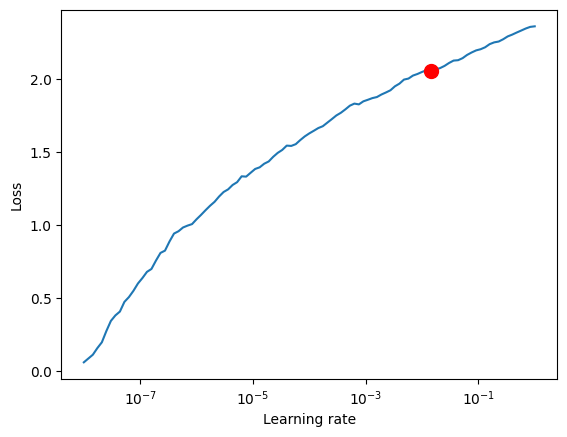

In [34]:
if TRAIN:
    trainer = train(BATCH_SIZE, datamodule, model, CoSpy, max_epochs = EPOCHS, max_steps = ITERS, check_val_every_n_epoch = None, load_model = LOAD_MODEL,
                    gradient_clip_val=GRADIENT_CLIPPING,
        resume_training = RESUME_TRAINING, monitor_metric = "train_loss", checkpoint_dir = CHECKPOINT_FOLDER,
        logs_dir = LOGS_FOLDER, early_stopping = False, deterministic = DETERMINISTIC, find_lr = FIND_LR)

##  Encoding

In [ ]:
def prepare_encoding(datamodule):
    datamodule.setup("encoding")
    loader = datamodule.encode_dataloader()
    return loader, datamodule.data.shape

def encode(model, data_shape, loader, batch_size, device, save_path):
    model.to(device)
    model = model.encoder_q
    res = model.encode(data_shape, loader, batch_size = batch_size, padding = PADDING)
    file_name = f"encoding_{time.time()}.pkl"
    pkl_save(f'{save_path}/{file_name}', res)
    pkl_save(f'{save_path}/last.pkl', res)
    log.info(f"encoding {file_name} saved")

    return res

In [ ]:
if EVALUATE:
    encoding_loader, data_shape = prepare_encoding(datamodule)
    # if LOAD_ENCODE:
    #     repr = pkl_load(ENCODING_FOLDER + "/last.pkl")
    # else:
    #     repr = encode(model, data_shape, encoding_loader, ENCODE_BATCH_SIZE, DEVICE, ENCODING_FOLDER)

## Forecasting Evaluation

In [ ]:
# Helper functions
def generate_pred_samples(features, data, pred_len, drop=0):
    n = data.shape[1]
    features = features[:, :-pred_len]
    labels = np.stack([ data[:, i:1+n+i-pred_len] for i in range(pred_len)], axis=2)[:, 1:]
    features = features[:, drop:]
    labels = labels[:, drop:]
    return features.reshape(-1, features.shape[-1]), labels.reshape(-1, labels.shape[2]*labels.shape[3])

def fit_ridge(train_features, train_y, valid_features, valid_y, MAX_SAMPLES=100000):
    # If the training set is too large, subsample MAX_SAMPLES examples
    if train_features.shape[0] > MAX_SAMPLES:
        split = train_test_split(
            train_features, train_y,
            train_size=MAX_SAMPLES, random_state=0
        )
        train_features = split[0]
        train_y = split[2]
    if valid_features.shape[0] > MAX_SAMPLES:
        split = train_test_split(
            valid_features, valid_y,
            train_size=MAX_SAMPLES, random_state=0
        )
        valid_features = split[0]
        valid_y = split[2]
    alphas = [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
    valid_results = []
    for alpha in alphas:
        lr = Ridge(alpha=alpha).fit(train_features, train_y)
        valid_pred = lr.predict(valid_features)
        score = np.sqrt(((valid_pred - valid_y) ** 2).mean()) + np.abs(valid_pred - valid_y).mean()
        valid_results.append(score)
    best_alpha = alphas[np.argmin(valid_results)]

    lr = Ridge(alpha=best_alpha)
    lr.fit(train_features, train_y)
    return lr

def cal_metrics(pred, target):
    return {
        'MSE': ((pred - target) ** 2).mean(),
        'MAE': np.abs(pred - target).mean()
    }

In [ ]:
def eval_forecasting(repr, data, train_slice, valid_slice, test_slice, n_covariate_cols, scaler, padding, pred_lens):
    train_repr = repr[:, train_slice]
    valid_repr = repr[:, valid_slice]
    test_repr = repr[:, test_slice]

    train_data = data[:, train_slice, n_covariate_cols:]
    valid_data = data[:, valid_slice, n_covariate_cols:]
    test_data = data[:, test_slice, n_covariate_cols:]

    ours_result = {}
    out_log = {}
    for pred_len in tqdm(pred_lens, desc="forecasting evaluation"):
        train_features, train_labels = generate_pred_samples(train_repr, train_data, pred_len, drop=padding)
        valid_features, valid_labels = generate_pred_samples(valid_repr, valid_data, pred_len)
        test_features, test_labels = generate_pred_samples(test_repr, test_data, pred_len)

        lr = fit_ridge(train_features, train_labels, valid_features, valid_labels)

        test_pred = lr.predict(test_features)

        ori_shape = test_data.shape[0], -1, pred_len, test_data.shape[2]
        test_pred = test_pred.reshape(ori_shape)
        test_labels = test_labels.reshape(ori_shape)

        test_shape = test_pred.shape
        test_shape_swap = (test_shape[3], test_shape[1], test_shape[2], test_shape[0])
        if test_data.shape[0] > 1:
            test_pred_inv = scaler.inverse_transform(test_pred.swapaxes(0, 3)
                .reshape(-1, test_shape[0])).reshape(test_shape_swap).swapaxes(0, 3)
            test_labels_inv = scaler.inverse_transform(test_labels.swapaxes(0, 3)
                .reshape(-1, test_shape[0])).reshape(test_shape_swap).swapaxes(0, 3)
        else:
            test_pred_inv = scaler.inverse_transform(test_pred.reshape(-1, test_shape[3])).reshape(test_shape)
            test_labels_inv = scaler.inverse_transform(test_labels.reshape(-1, test_shape[3])).reshape(test_shape)

        # out_log[pred_len] = {
        #     # 'norm': test_pred,
        #     # 'raw': test_pred_inv
        #     # 'norm_gt': test_labels,
        #     # 'raw_gt': test_labels_inv
        # }
        ours_result[pred_len] = {
            'norm': cal_metrics(test_pred, test_labels),
            'raw': cal_metrics(test_pred_inv, test_labels_inv)
        }
        print(ours_result)

    eval_res = {
        'ours': ours_result
    }
    return out_log, eval_res

In [ ]:
if EVALUATE:
    train_slice = datamodule.train_slice
    valid_slice = datamodule.valid_slice
    test_slice = datamodule.test_slice
    data = datamodule.data
    n_covariate_cols = datamodule.n_covariate_cols
    scaler = datamodule.scaler
    padding = PADDING
    pred_lens = datamodule.pred_lens
    repr=data # REMOVE

    out, eval_res = eval_forecasting(repr, data, train_slice, valid_slice, test_slice,
                                    n_covariate_cols, scaler, padding, pred_lens)

    wandb.log({"eval_forecasting": eval_res})
    pkl_save(FORECASTING_RESULT + "/out.pkl", out)
    pkl_save(FORECASTING_RESULT + "/eval_res.pkl", eval_res)